# Serie Temporal e Predição

### Esse notebook tem por objetivo, consumir os dados públicos de índice de atividade econômica do banco central, disponibilizado no site: [Portal Brasileiro de Dados Abertos](https://dados.gov.br)
### Com esses dados, foi criado um gráfico de série temporal e também uma predição atráves dos dados históricos, para alguns meses a frente, elucidando também, os limites superiores e inferiores a mesma.



In [2]:
# Importando bibliotecas a serem utilizadas.
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import datetime

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
# importando os dados para um dataframe.
url = "http://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=csv&dataInicial=01/01/2016&dataFinal=01/05/2021"
df = pd.read_csv(url,sep=";")
df.valor = df.valor.str.replace(',', '.').astype(float)
df

,data,valor
0,01/01/2016,128.48
1,01/02/2016,130.93
2,01/03/2016,140.53
3,01/04/2016,136.07
4,01/05/2016,133.75
...,...,...
57,01/10/2020,139.45
58,01/11/2020,138.01
59,01/12/2020,139.69
60,01/01/2021,132.90


In [4]:
# Convertendo o atributo "data" para o formato datetime e setando o campo como índice.
df.data = pd.to_datetime(df.data, format="%d/%m/%Y")
df.set_index('data', inplace=True)

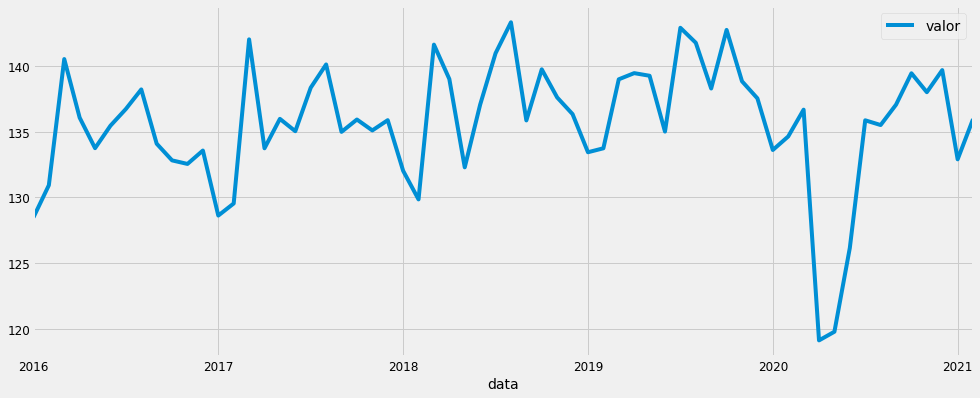

In [5]:
# plotando o gráfico simples de série temporal.
df.plot(figsize=(15, 6))
plt.show()

#### Utilizando o pacote statsmodels, podemos usar o metodo seasonal_decompose para dividir o gráfico em partes, ficando assim mais fácil e vísivel de fazer uma análise exploratória.
#### O 1º gráfico é o de observação original;
#### O 2º é o gráfico de tendencias ( direção no qual o indicador está se desenvolvendo ou evoluindo);
#### o 3º é o de sazonalidade ( qualquer mudança ou padrão previsível );
#### Por último o gráfico residual ( que é tudo que não pode ser identificado ou separado da observação original)



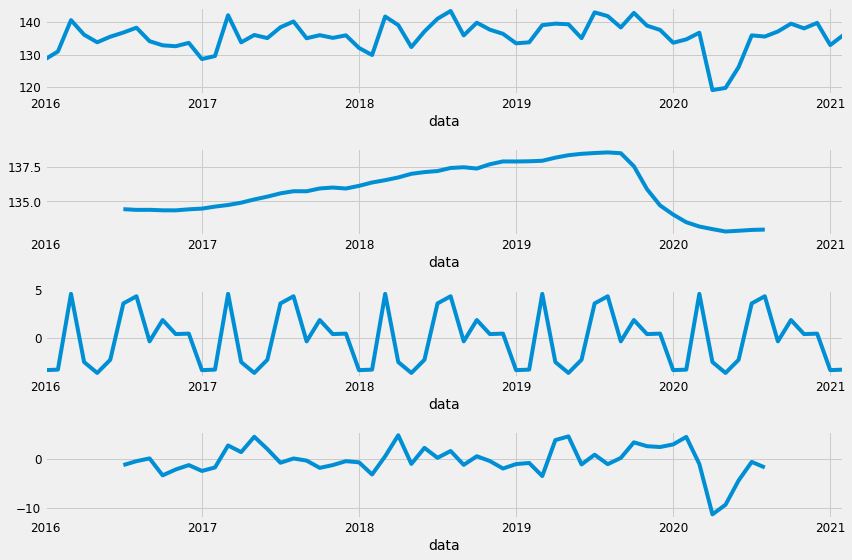

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(df)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))
resultado.observed.plot(ax=ax1)
resultado.trend.plot(ax=ax2)
resultado.seasonal.plot(ax=ax3)
resultado.resid.plot(ax=ax4)
plt.tight_layout()

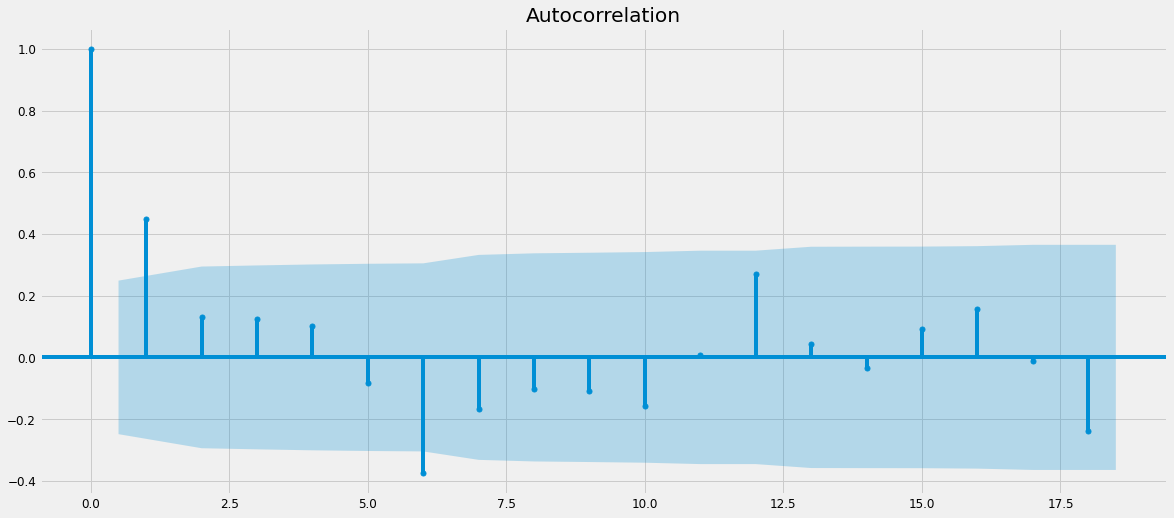

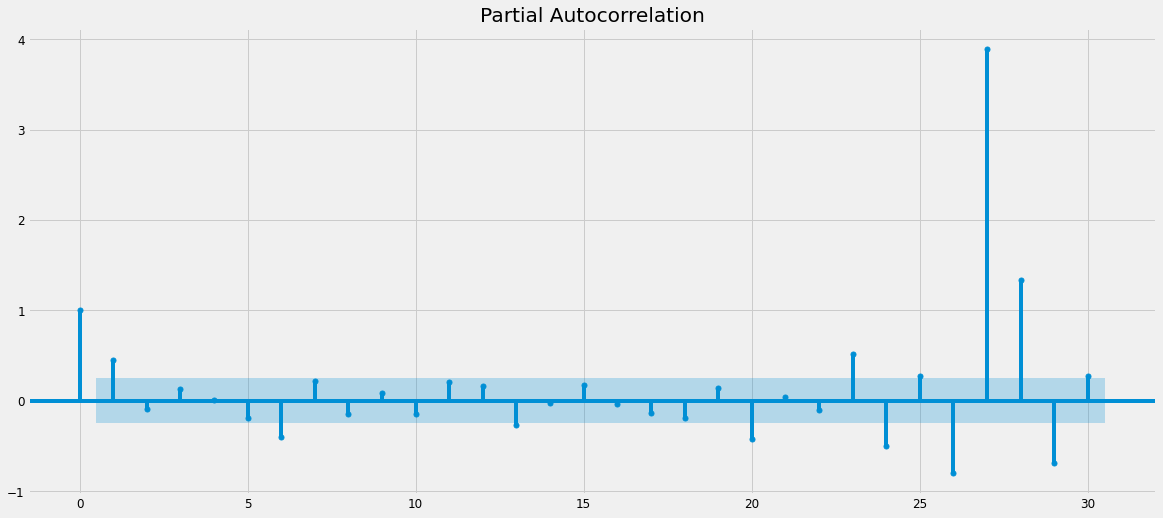

In [16]:
# imprimindo gráfico de autocorrelação e correlação parcial para identificar os valores dos parâmetros p e q do ARIMA.
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(df)
plot_pacf(df, lags=30)
plt.show()

####  treinando o modelo usando a sasonalizada como 12 que é comum em dados mensais.  Se fossem dados diários, utilizaríamos sasonalidade = 7.
#### Modelo utilizado foi o ARIMA, que é um dos mais usados nos casos de predição, cuja sigla significa AutoRegressive Integrated Moving Average. Ele pode "prever" o futuro utitilizando dados do passado. É baseado principalmente em medias móveis e autocorrelação.
#### É interessante usá-lo, pois ele é capaz de identificar e considerar a sazonalidade.
#### obs: método "fit" é usado para treinar o modelo.

C:\Users\Inaiah\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Inaiah\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


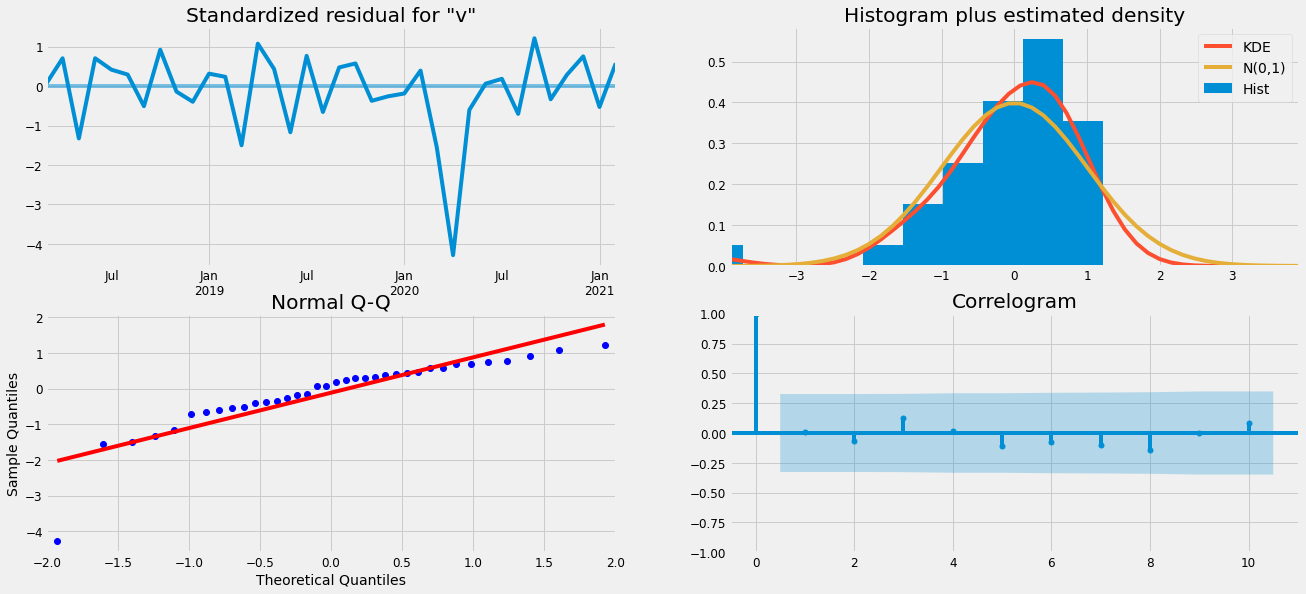

In [18]:
train = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

resultado = train.fit()

resultado.plot_diagnostics(figsize=(20,9))
plt.show()

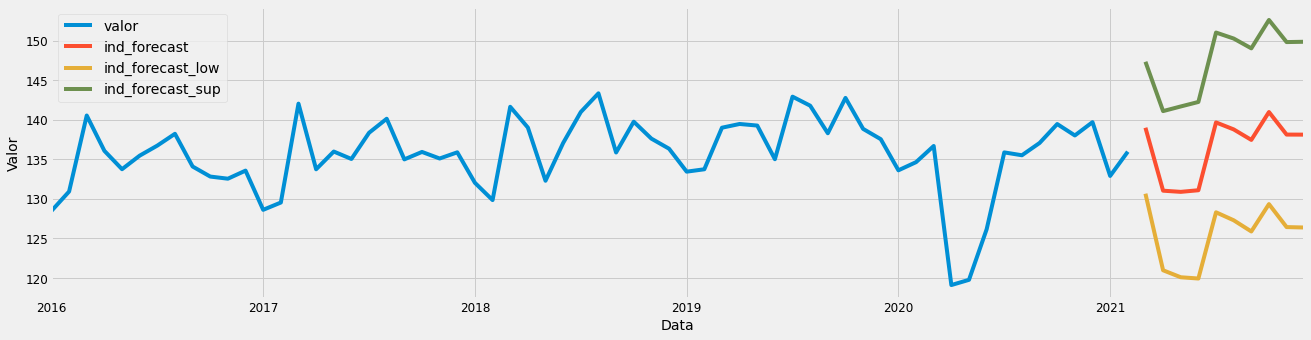

In [19]:
# imprimindo o gráfico com a predição futura e os intervalos acima e abaixo:
pred_mod = resultado.get_forecast(steps=10)
pred_interv = pred_mod.conf_int()

ax = df.plot(label='observed', figsize=(20, 5))
pred_mod.predicted_mean.plot(ax=ax, label='ind_forecast')
pred_interv.iloc[:, 0].plot(ax=ax, label='ind_forecast_low')
pred_interv.iloc[:, 1].plot(ax=ax, label='ind_forecast_sup')
ax.set_xlabel('Data')
ax.set_ylabel('Valor')

plt.legend()
plt.show()